# Exploring the capabilities of the Transformers model.

This notebook implements a Transformers architecture with only layer which is repeated a certain number of time; we investigate how this architecture succeeds to learn modular addition. Besides, we investigate the learned parameters, the impact of depth of this Transformers. We remind that the Transformers model we propose is the following
$$x_{k}^{i+1}=x_{k}^{i}+\sum_{j=1}^{n}\frac{e^{\langle Qx_{k}^{i},K x_{j}^{i}\rangle}}{\sum_{t=1}^{n}e^{\langle Qx_{t}^{i},K x_{k}^{i}\rangle}}Vx_{j}^{i}.$$
We can see this model as an equivalent of the ResNet neural networks for Transformers with a same attention head which is repeated through the layers. We investigate the different performances according to depth.

# Imports and implementation

### Imports

In [1]:
!nvidia-smi

Thu Feb  1 08:19:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install seaborn

In [3]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00


In [4]:
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from tqdm.auto import tqdm
import math
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import torch.optim

In [5]:
Z=sns.color_palette("Paired")

### Transformer implementation

In [6]:
alpha=1
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(alpha*torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(alpha*torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(alpha*torch.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(alpha*torch.ones(d_model))
        self.b_ln = nn.Parameter(alpha*torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Linear(d_head, d_model)
        self.W_Q = nn.Linear(d_head, d_model)
        self.W_V = nn.Linear(d_head, d_model)
        self.W_O = nn.Linear(d_model, d_head )
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head

    def forward(self, x):
      ###computation of the scalar products
        W_k=self.W_K.weight
        W_q=self.W_Q.weight
        W_v=self.W_V.weight
        W_o=self.W_O.weight
        k =torch.einsum('hd,bpd->bph', W_k, x)
        q = torch.einsum('hd,bpd->bph',W_q, x)
        v = torch.einsum('hd,bpd->bph', W_v, x)
        attn_scores_pre = torch.einsum('bph,bqh->bqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = F.softmax((attn_scores_masked/np.sqrt(self.d_head)), dim=-1)
        z = torch.einsum('bph,bqp->bqh', v, attn_matrix)
        z_flat = einops.rearrange(z, 'b q h -> b q (h)')
        out = torch.einsum('df,bqf->bqd', W_o, z_flat)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model    #512 dim
        self.num_heads = num_heads   #8
        self.single_head_dim = int(self.d_model / self.num_heads)   #512/8 = 64  . each key,query, value will be of 64d

        #key,query and value matrixes    #64 x 64
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.num_heads*self.single_head_dim ,self.d_model)

    def forward(self,x,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512

        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        batch_size = x.size(0)
        seq_length = x.size(1)

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        #seq_length_query = query.size(1)

        # 32x10x512
        key = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim) #(32x10x8x64)
        value = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim) #(32x10x8x64)

        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)

        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))
        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim)
        #applying softmax
        scores = F.softmax(product, dim=-1)
        #mutiply with value matrix
        scores = torch.matmul(scores, v)
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length, self.single_head_dim*self.num_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)

        output = self.out(concat) #(32,10,512) -> (32,10,512)

        return output
# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(alpha*torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(alpha*torch.zeros(d_mlp))
        self.W_out = nn.Parameter(alpha*torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        self.ln = LayerNorm(d_mlp, model=self.model)
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = MultiHeadAttention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)

    def forward(self, x):
        x = x + self.attn(x)
        #x = x + self.mlp(x)
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type,depth, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache
        self.depth=depth

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        #for name, module in self.named_modules():
            #if type(module)==HookPoint:
             #   module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
          for i in range(self.depth):
            x = block(x)
        #x = self.ln(x)
        x = self.unembed(x)
        ##mettre un pooling

        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache


### Baseline training run

In [7]:
def full_loss(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    return torch.nn.functional.cross_entropy(logits, labels)

def full_accuracy(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    predictions = torch.argmax(logits, dim=1)
    return torch.sum(predictions == labels).item() / len(labels)

## Data

In [110]:
seed = 42
p = 113
fraction = 0.6
equals_token= p

In [111]:
device='cuda'

In [112]:
equals_token = p

x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
plus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+1)
prompts = torch.stack([x, plus, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])
equals_token = p

# Training loop for modular addition (depth=2)

### Model declaration

In [113]:
model_2 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=False, # use LayerNorm,
                    depth=2
                ).to(device)
np.random.seed(42)

### Training

In [114]:
optimizer = torch.optim.AdamW(model_2.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=90, threshold=10e-8,verbose=True)
log_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
test_minus= []
norms = []
Attn_wk_m=[]
Attn_wq_m=[]
Attn_wv_m=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_2, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_2.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m.append(model_2.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m.append(model_2.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m.append(model_2.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps.append(epoch)
          test_loss = full_loss(model_2, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses.append(train_loss.item())
          test_losses.append(test_loss.item())
          train_accuracies.append(full_accuracy(model_2, train, device))
          test_accuracies.append(full_accuracy(model_2, test, device))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f "%(epoch, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 4.766060 |  Test loss: 4.762914 | train_acc: 0.01 | test_acc: 0.01 
epoch: 30  | Train loss: 4.697515 |  Test loss: 4.791189 | train_acc: 0.02 | test_acc: 0.00 
epoch: 60  | Train loss: 4.581234 |  Test loss: 5.116682 | train_acc: 0.03 | test_acc: 0.00 
epoch: 90  | Train loss: 4.393941 |  Test loss: 5.320343 | train_acc: 0.04 | test_acc: 0.00 
epoch: 120  | Train loss: 4.230212 |  Test loss: 5.412734 | train_acc: 0.05 | test_acc: 0.00 
epoch: 150  | Train loss: 4.105597 |  Test loss: 5.491032 | train_acc: 0.07 | test_acc: 0.00 
epoch: 180  | Train loss: 4.009339 |  Test loss: 5.524130 | train_acc: 0.08 | test_acc: 0.00 
epoch: 210  | Train loss: 3.913565 |  Test loss: 5.480446 | train_acc: 0.10 | test_acc: 0.01 
epoch: 240  | Train loss: 3.821530 |  Test loss: 5.435915 | train_acc: 0.12 | test_acc: 0.01 
epoch: 270  | Train loss: 3.734209 |  Test loss: 5.376550 | train_acc: 0.14 | test_acc: 0.01 
epoch: 300  | Train loss: 3.669260 |  Test loss: 5.312628 | train

Exception ignored in: <function _xla_gc_callback at 0x78ee46a03250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


epoch: 11640  | Train loss: 1.255819 |  Test loss: 1.308173 | train_acc: 0.75 | test_acc: 0.65 
epoch: 11670  | Train loss: 1.257331 |  Test loss: 1.309496 | train_acc: 0.75 | test_acc: 0.64 


KeyboardInterrupt: 

## Vizualization of the accuracy, rank and weight models dynamics

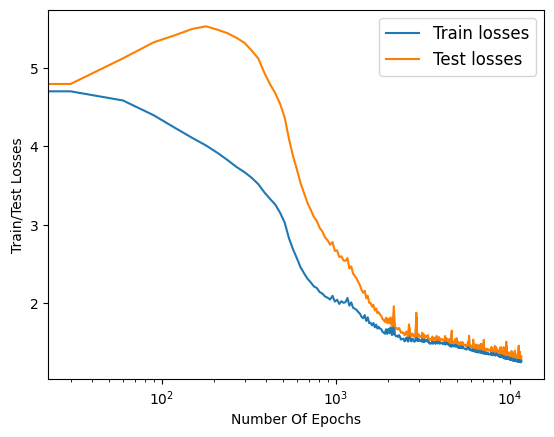

In [115]:
plt.figure
plt.plot(log_steps,train_losses, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (391,) and (390,)

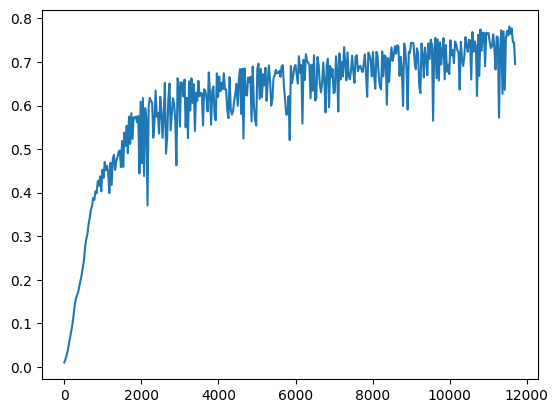

In [116]:
plt.figure
plt.plot(log_steps,train_accuracies , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

In [ ]:
rank_wk=[np.linalg.matrix_rank(x) for x in Attn_wk_m]
rank_wq_m=[np.linalg.matrix_rank(x) for x in Attn_wq_m]
rank_wv_m=[np.linalg.matrix_rank(x) for x in Attn_wv_m]

In [ ]:
rk_wk=[x/128 for x in rank_wk]
rk_wq=[x/128 for x in rank_wq_m]
rk_wv=[x/128 for x in rank_wv_m]

In [199]:
eigenvalues, eigenvectors = np.linalg.eig(Attn_wv_m[-1])

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100,figsize=[35,8])

ax[0].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
ax[0].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
ax[0].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[0].plot(log_steps, train_accuracies, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[0].plot(log_steps, test_accuracies, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[0].legend()
ax[0].set_ylabel('Rank of attention matrices',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 3*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')
#ax[1].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

ax[1].plot(log_steps, train_losses, color=Z[5],linewidth=3, label='Train loss',zorder=3)
ax[1].plot(log_steps, test_losses, color=Z[4],linewidth=3, label='Test loss',zorder=3)
#ax[2].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
#ax[2].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
#ax[2].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Losses',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 3*10**4)
ax[1].set_xscale('log')
##ax[2].set_yscale('log')
ax[1].legend(fontsize='large')
#ax[2].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

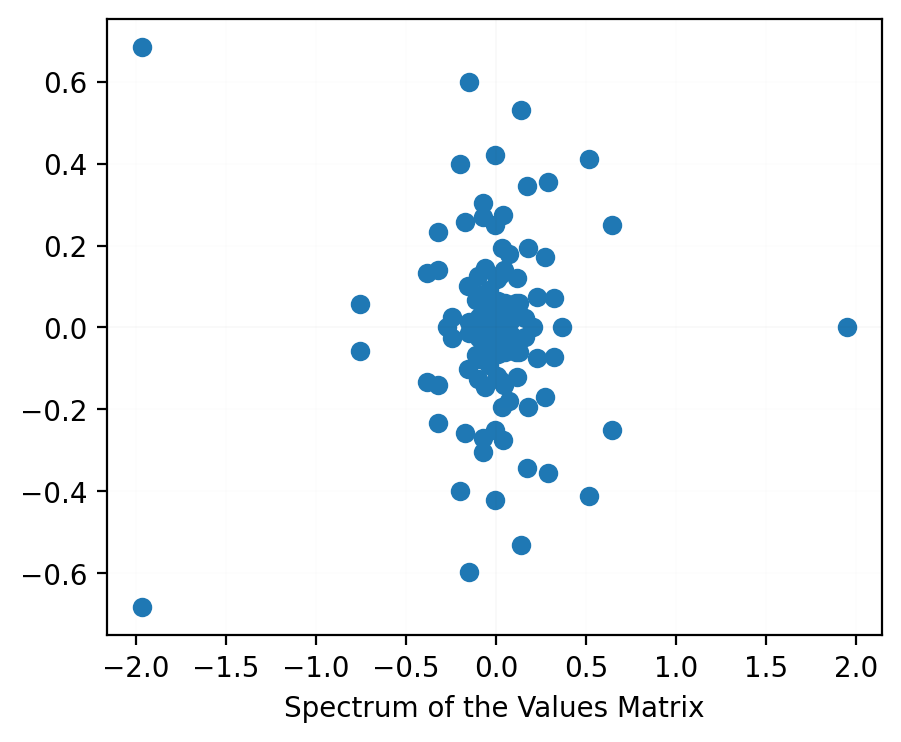

In [201]:
plt.figure(figsize=[5,4],dpi=200)
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of the Values Matrix')
filename='V_2_FINAL.png'
plt.savefig(filename)

# LoRA Fine-tuning (depth=2)

##Parameter of the model

In [129]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

Hyperparameters of the training

In [130]:
!pip install peft

In [131]:
import peft
import copy
import os

## Fine-tuning Configuration ($r=4$ as LoRA rank \text{ and } $V$ as unique parameter which is modified).

In [132]:
config = peft.LoraConfig(
    r=16,
    target_modules=["blocks.0.attn.value_matrix"]
)
lr=10e-5
model=model_2
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.AdamW(peft_model.parameters(), lr, betas=(0.9, 0.98))

peft_model.print_trainable_parameters()

trainable params: 4,096 || all params: 232,960 || trainable%: 1.7582417582417582


## Fine-tuning

In [133]:
lr=1e-5
wd=0.
epochs=15000

In [134]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [135]:
epochs=10000
train = data_train
test = data_test
Attn_wv_A_ft2=[]
Attn_wv_B_ft2=[]
Attn_wq_A_ft2=[]
Attn_wq_B_ft2=[]
Attn_wk_BAft2=[]
Attn_wk_B_ft2=[]
log_steps = []
train_losses__ft1 = []
test_losses__ft1= []
train_accuracies__ft1 = []
test_accuracies__ft1 = []
test_accuracies__ft_plus1 = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(peft_model, train, device)
  if epoch % 30 == 0:
    for param_tensor in peft_model.state_dict():
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_A.default.weight':
            Attn_wv_A_ft2.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_B.default.weight':
            Attn_wv_B_ft2.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus1.append(full_accuracy(peft_model, data_test_plus, device))
            test_loss__1 = full_loss(peft_model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft1.append(train_loss.item())
            test_losses__ft1.append(test_loss__1.item())
            train_accuracies__ft1.append(full_accuracy(peft_model, train, device))
            test_accuracies__ft1.append(full_accuracy(peft_model, test, device))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | Test_mod_add: %.6f  "%(epoch, train_losses__ft1[-1], test_losses__ft1[-1], train_accuracies__ft1[-1], test_accuracies__ft1[-1],test_accuracies__ft_plus1[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 341.284790 |  Test loss: 353.411926 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.655024  
epoch: 30  | Train loss: 340.300903 |  Test loss: 352.380951 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.659723  
epoch: 60  | Train loss: 338.508179 |  Test loss: 350.505524 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.643355  
epoch: 90  | Train loss: 335.779236 |  Test loss: 347.651367 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.610619  
epoch: 120  | Train loss: 332.153809 |  Test loss: 343.853882 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.520636  
epoch: 150  | Train loss: 327.701996 |  Test loss: 339.173401 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.436134  
epoch: 180  | Train loss: 322.450134 |  Test loss: 333.618225 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.366983  
epoch: 210  | Train loss: 316.323090 |  Test loss: 327.086853 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.309656  
epoch: 240  |

## Vizualization of Loss, Accuracies curves

In [183]:
l=[30*i+10 for i in range(len(train_accuracies__ft1))]
train_accuracies__ft1

[0.007049608355091384,
 0.007049608355091384,
 0.007571801566579634,
 0.007310704960835509,
 0.006527415143603133,
 0.007310704960835509,
 0.008616187989556136,
 0.00835509138381201,
 0.009921671018276762,
 0.010443864229765013,
 0.010704960835509139,
 0.010704960835509139,
 0.009138381201044387,
 0.010704960835509139,
 0.009399477806788513,
 0.008616187989556136,
 0.009660574412532636,
 0.008093994778067885,
 0.00835509138381201,
 0.009921671018276762,
 0.010182767624020888,
 0.009921671018276762,
 0.007571801566579634,
 0.007832898172323759,
 0.007310704960835509,
 0.006527415143603133,
 0.0060052219321148825,
 0.006788511749347258,
 0.006527415143603133,
 0.007310704960835509,
 0.007571801566579634,
 0.005221932114882507,
 0.006527415143603133,
 0.004699738903394256,
 0.006527415143603133,
 0.006266318537859008,
 0.007310704960835509,
 0.007310704960835509,
 0.007571801566579634,
 0.00835509138381201,
 0.006527415143603133,
 0.009399477806788513,
 0.009921671018276762,
 0.0109660574

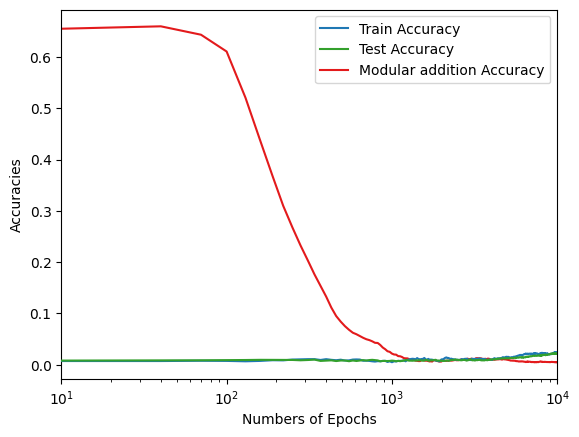

In [189]:
plt.plot(l, train_accuracies__ft1, color=Z[1], label='Train Accuracy ',zorder=3)
plt.plot(l, test_accuracies__ft1, color=Z[3], label='Test Accuracy',zorder=3)
plt.plot(l,test_accuracies__ft_plus1, color=Z[5], label='Modular addition Accuracy')
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(10, 10**4)
plt.xscale('log')
plt.ylabel("Accuracies")
plt.legend()
basename='ACC_2.png'
plt.savefig(basename)

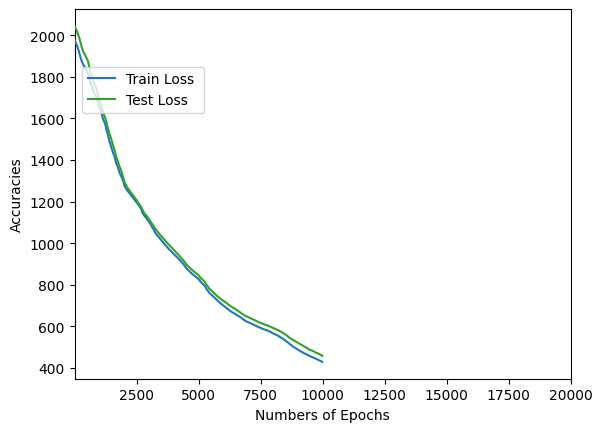

In [ ]:
plt.plot(log_steps, train_losses__ft1, color=Z[1], label='Train Loss ',zorder=3)
plt.plot(log_steps, test_losses__ft1, color=Z[3], label='Test Loss',zorder=3)
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(1, 2*10**4)
plt.ylabel("Accuracies")
plt.legend(loc=(0.015, 0.72))

In [140]:
lora_A=model.blocks[0].attn.value_matrix.lora_A.default.weight.cpu().detach().numpy()
lora_B=model.blocks[0].attn.value_matrix.lora_B.default.weight.cpu().detach().numpy()
deltaW=lora_B@lora_A
eigenvalues_2=np.linalg.eigvals(Attn_wv_m[-1])
eigenvalues_3=np.linalg.eigvals(Attn_wv_m[-1]+deltaW)

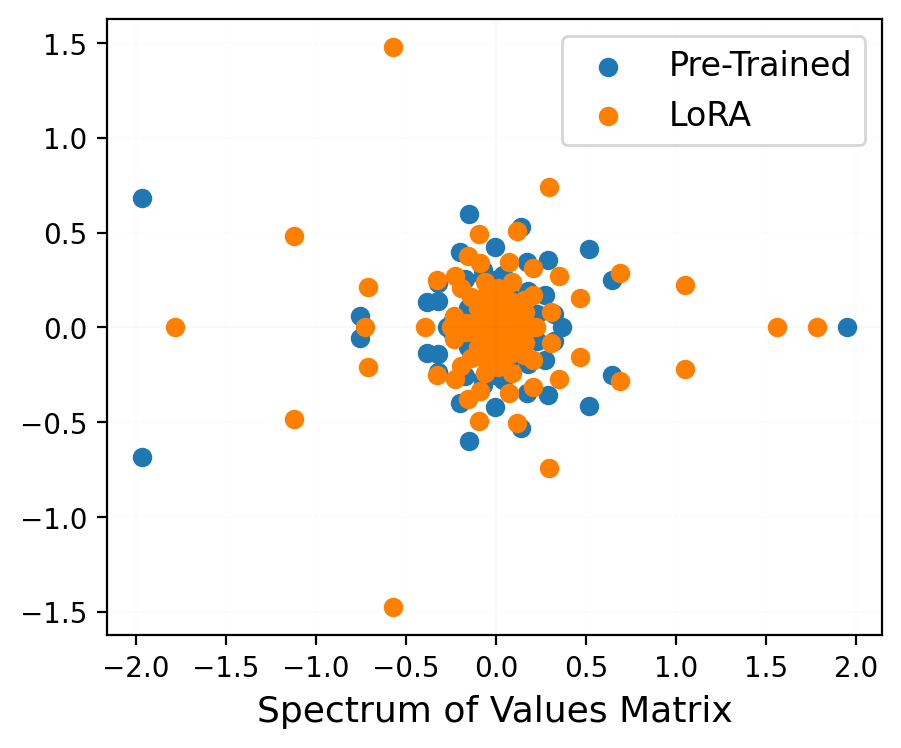

In [150]:
plt.figure(figsize=[5,4],dpi=200)
plt.scatter(np.real(eigenvalues_2), np.imag(eigenvalues_2), marker='o', color=Z[1],label='Pre-Trained')
plt.scatter(np.real(eigenvalues_3), np.imag(eigenvalues_3), marker='o', color=Z[7],label='LoRA')
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of Values Matrix',fontsize='13')
plt.legend()
plt.legend(fontsize='large')
basename='LoRA_2_V_FINAL_vrai.png'
plt.savefig(basename)

# Training loop for modular addition (depth=4)

### Model declaration

In [11]:
model_4 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=False, # use LayerNorm,
                    depth=4
                ).to(device)

### Training

In [12]:
optimizer = torch.optim.AdamW(model_4.parameters(), lr=1e-3, weight_decay=.4, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=90, threshold=10e-8,verbose=True)
log_steps_4 = []
train_losses_4 = []
test_losses_4= []
train_accuracies_4 = []
test_accuracies_4 = []
Attn_wk_m_4=[]
Attn_wq_m_4=[]
Attn_wv_m_4=[]
for epoch in tqdm(range(30000)):
  train_loss = full_loss(model_4, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_4.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_4.append(epoch)
          test_loss_4 = full_loss(model_4, test, device)
          test_2,train_2= test_loss_4.item(),train_loss.item()
          train_losses_4.append(train_loss.item())
          test_losses_4.append( test_loss_4.item())
          train_accuracies_4.append(full_accuracy(model_4, train, device))
          test_accuracies_4.append(full_accuracy(model_4, test, device))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f"%(epoch, train_losses_4[-1], test_losses_4[-1], train_accuracies_4[-1], test_accuracies_4[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/30000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 4.803520 |  Test loss: 4.799559 | train_acc: 0.01 | test_acc: 0.01
epoch: 30  | Train loss: 4.680618 |  Test loss: 4.854013 | train_acc: 0.02 | test_acc: 0.00
epoch: 60  | Train loss: 4.559970 |  Test loss: 5.234907 | train_acc: 0.03 | test_acc: 0.00
epoch: 90  | Train loss: 4.379730 |  Test loss: 5.411160 | train_acc: 0.04 | test_acc: 0.00
epoch: 120  | Train loss: 4.239041 |  Test loss: 5.501244 | train_acc: 0.04 | test_acc: 0.00
epoch: 150  | Train loss: 4.145280 |  Test loss: 5.594567 | train_acc: 0.05 | test_acc: 0.00
epoch: 180  | Train loss: 4.068704 |  Test loss: 5.702348 | train_acc: 0.06 | test_acc: 0.00
epoch: 210  | Train loss: 4.004260 |  Test loss: 5.793965 | train_acc: 0.07 | test_acc: 0.00
epoch: 240  | Train loss: 3.943841 |  Test loss: 5.889931 | train_acc: 0.08 | test_acc: 0.00
epoch: 270  | Train loss: 3.888932 |  Test loss: 5.948907 | train_acc: 0.10 | test_acc: 0.01
epoch: 300  | Train loss: 3.837198 |  Test loss: 6.009783 | train_acc: 0.11

## Vizualization of the accuracy, rank and weight models dynamics

In [ ]:
plt.figure
plt.plot(log_steps_4,train_losses_4, color=Z[1],label='Train losses')
plt.plot(log_steps_4,test_losses_4, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.ylim([0,10])
plt.xlim([1,20000])
plt.show()

In [ ]:
plt.figure
plt.plot(log_steps_4 ,train_accuracies_4 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps_4 ,test_accuracies_4, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.xlim([1,20000])
plt.show()

In [202]:
eigenvalues, eigenvectors = np.linalg.eig(Attn_wv_m_4[-1])

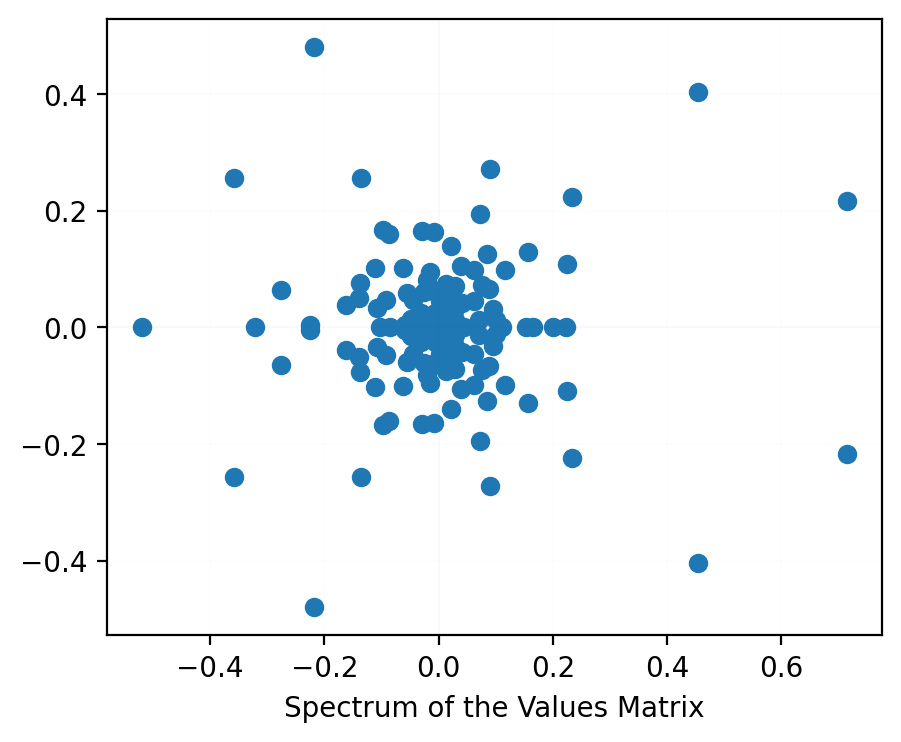

In [203]:
plt.figure(figsize=[5,4],dpi=200)
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of the Values Matrix')
filename='V_4_FInal_VDV.png'
plt.savefig(filename)
#plt.legend()
#plt.legend(fontsize='large')

# LoRA Fine-tuning (depth=4)

##Parameter of the model

In [17]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

Hyperparameters of the training

In [18]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.8 MB/s eta 0:00:00


In [19]:
import peft
import copy
import os

## Fine-tuning Configuration ($r=4$ as LoRA rank \text{ and } $V$ as unique parameter which is modified).

In [20]:
config = peft.LoraConfig(
    r=16,
    target_modules=["blocks.0.attn.value_matrix"]
)
lr=10e-5
model=model_4
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.AdamW(peft_model.parameters(), lr, betas=(0.9, 0.98))

peft_model.print_trainable_parameters()

trainable params: 4,096 || all params: 232,960 || trainable%: 1.7582417582417582


## Fine-tuning

In [21]:
lr=1e-5
wd=0.
epochs=15000

In [22]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [167]:
epochs=10000
train = data_train
test = data_test
#Attn_wv_A_ft1=[]
#Attn_wv_B_ft1=[]
#Attn_wq_ft1=[]
#Attn_wk_ft1=[]
#log_steps = []
#train_losses__ft1 = []
#test_losses__ft1= []
#train_accuracies__ft1 = []
#test_accuracies__ft1 = []
#test_accuracies__ft_plus1 = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(peft_model, train, device)
  if epoch % 30 == 0:
    for param_tensor in peft_model.state_dict():
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_A.default.weight':
            Attn_wv_A_ft1.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_B.default.weight':
            Attn_wv_B_ft1.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus1.append(full_accuracy(peft_model, data_test_plus, device))
            test_loss__1 = full_loss(peft_model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft1.append(train_loss.item())
            test_losses__ft1.append(test_loss__1.item())
            train_accuracies__ft1.append(full_accuracy(peft_model, train, device))
            test_accuracies__ft1.append(full_accuracy(peft_model, test, device))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | Test_mod_add: %.6f  "%(epoch, train_losses__ft1[-1], test_losses__ft1[-1], train_accuracies__ft1[-1], test_accuracies__ft1[-1],test_accuracies__ft_plus1[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 4.224139 |  Test loss: 4.246803 | train_acc: 0.02 | test_acc: 0.02 | Test_mod_add: 0.004934  
epoch: 30  | Train loss: 4.220173 |  Test loss: 4.242902 | train_acc: 0.02 | test_acc: 0.02 | Test_mod_add: 0.004934  
epoch: 60  | Train loss: 4.215981 |  Test loss: 4.238842 | train_acc: 0.03 | test_acc: 0.02 | Test_mod_add: 0.004934  
epoch: 90  | Train loss: 4.211793 |  Test loss: 4.234865 | train_acc: 0.03 | test_acc: 0.02 | Test_mod_add: 0.005090  
epoch: 120  | Train loss: 4.207414 |  Test loss: 4.230770 | train_acc: 0.03 | test_acc: 0.02 | Test_mod_add: 0.005169  
epoch: 150  | Train loss: 4.202909 |  Test loss: 4.226591 | train_acc: 0.03 | test_acc: 0.02 | Test_mod_add: 0.005169  
epoch: 180  | Train loss: 4.198241 |  Test loss: 4.222030 | train_acc: 0.03 | test_acc: 0.02 | Test_mod_add: 0.005169  
epoch: 210  | Train loss: 4.193730 |  Test loss: 4.217866 | train_acc: 0.03 | test_acc: 0.02 | Test_mod_add: 0.005404  
epoch: 240  | Train loss: 4.189147 |  Test lo

Exception ignored in: <function _xla_gc_callback at 0x78ee46a03250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


epoch: 4110  | Train loss: 3.846732 |  Test loss: 3.898775 | train_acc: 0.04 | test_acc: 0.03 | Test_mod_add: 0.011277  
epoch: 4140  | Train loss: 3.845393 |  Test loss: 3.897386 | train_acc: 0.04 | test_acc: 0.03 | Test_mod_add: 0.010964  
epoch: 4170  | Train loss: 3.844129 |  Test loss: 3.896020 | train_acc: 0.04 | test_acc: 0.04 | Test_mod_add: 0.010807  


Exception ignored in: <function _xla_gc_callback at 0x78ee46a03250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


epoch: 4200  | Train loss: 3.842963 |  Test loss: 3.895357 | train_acc: 0.04 | test_acc: 0.03 | Test_mod_add: 0.010886  


KeyboardInterrupt: 

## Vizualization of Loss, Accuracies curves

In [169]:
l=[30*i+10 for i in range(len(train_accuracies__ft1))]

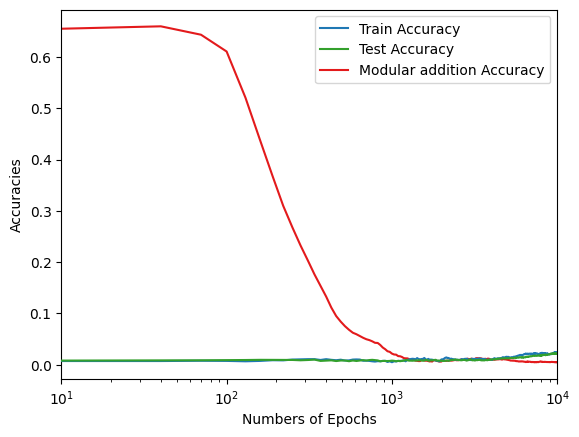

In [172]:
plt.plot(l, train_accuracies__ft1, color=Z[1], label='Train Accuracy ',zorder=3)
plt.plot(l, test_accuracies__ft1, color=Z[3], label='Test Accuracy',zorder=3)
plt.plot(l,test_accuracies__ft_plus1, color=Z[5], label='Modular addition Accuracy')
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(10, 10**4)
plt.xscale('log')
plt.ylabel("Accuracies")
filename = "ACC_4"
plt.savefig(filename)
plt.legend()
plt.show()

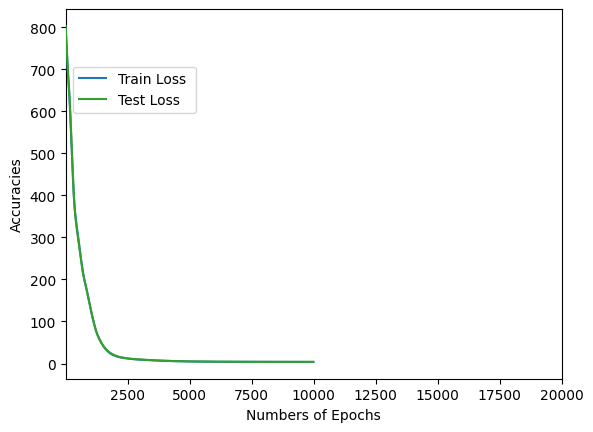

In [25]:
plt.plot(log_steps, train_losses__ft1, color=Z[1], label='Train Loss ',zorder=3)
plt.plot(log_steps, test_losses__ft1, color=Z[3], label='Test Loss',zorder=3)
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(1, 2*10**4)
plt.ylabel("Accuracies")
plt.legend(loc=(0.015, 0.72))

In [26]:
wk= [Attn_wk_ft1[i] for i in range(len(Attn_wk_ft1))]
wq= [Attn_wq_ft1[i] for i in range(len(Attn_wq_ft1))]
#wv= [(Attn_wv_ft1[i]-Attn_wv_m_4[-1]) for i in range(len(Attn_wv_ft1))]

In [68]:
lora_A=model.blocks[0].attn.value_matrix.lora_A.default.weight.cpu().detach().numpy()
lora_B=model.blocks[0].attn.value_matrix.lora_B.default.weight.cpu().detach().numpy()
deltaW=lora_B@lora_A
wv= [(Attn_wv_A_ft1[i]@Attn_wv_B_ft1[i]) for i in range(len(Attn_wv_A_ft1))]

In [36]:
deltaW

array([[ 0.03891607, -0.1243268 ,  0.03465748, ..., -0.00723527,
         0.06685621, -0.15879679],
       [-0.12394741, -0.06792545,  0.03445353, ...,  0.06585246,
         0.12354345, -0.19959876],
       [-0.0999126 , -0.04193393, -0.01481254, ...,  0.00355974,
         0.05076361, -0.13287562],
       ...,
       [-0.10622048,  0.25362754,  0.2798822 , ...,  0.14687967,
        -0.17215365,  0.05218159],
       [-0.0317401 ,  0.09907345, -0.00103958, ..., -0.08993381,
         0.06665708, -0.03201018],
       [ 0.0815816 , -0.23859468, -0.380776  , ..., -0.31653154,
         0.2873861 , -0.12299563]], dtype=float32)

In [173]:
lora_A=model.blocks[0].attn.value_matrix.lora_A.default.weight.cpu().detach().numpy()
lora_B=model.blocks[0].attn.value_matrix.lora_B.default.weight.cpu().detach().numpy()
deltaW=lora_B@lora_A
eigenvalues=np.linalg.eigvals(deltaW)
eigenvalues_2=np.linalg.eigvals(Attn_wv_m_4[-1])
eigenvalues_3=np.linalg.eigvals(Attn_wv_m_4[-1]+deltaW)

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]
spv=[np.linalg.eigvals(x) for x in wv]

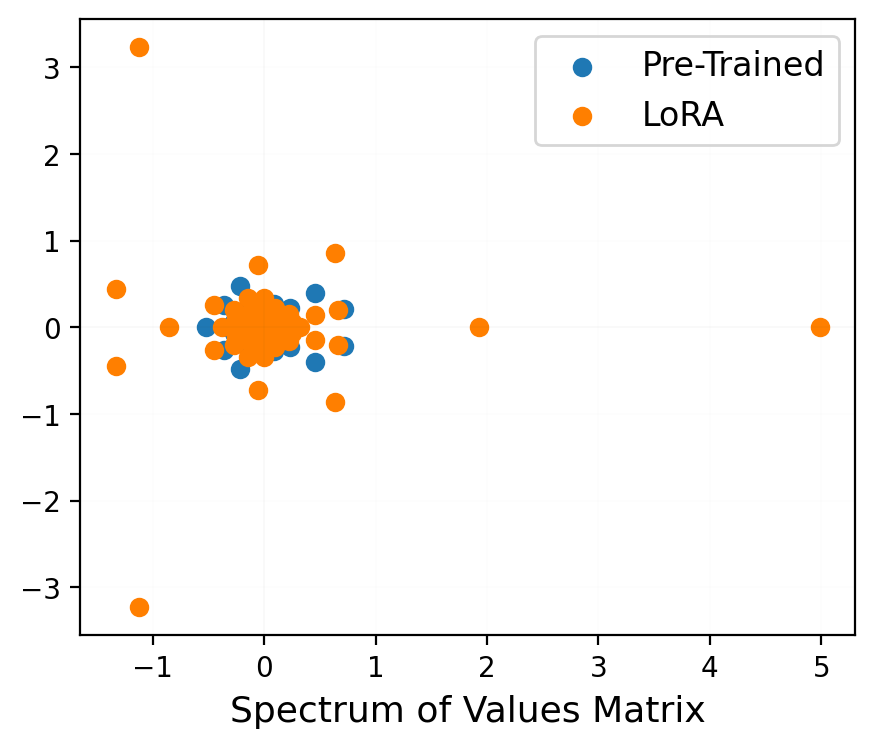

In [175]:
plt.figure(figsize=[5,4],dpi=200)
plt.scatter(np.real(eigenvalues_2), np.imag(eigenvalues_2), marker='o', color=Z[1],label='Pre-Trained')
#plt.scatter(np.real(eigenvalues_2), np.imag(eigenvalues_2), marker='o', color=Z[5])
plt.scatter(np.real(eigenvalues_3), np.imag(eigenvalues_3), marker='o', color=Z[7],label='LoRA')
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of Values Matrix',fontsize='13')
filename='V_4.png'
plt.legend()
plt.legend(fontsize='large')
plt.savefig(filename)

# Training loop for modular addition (depth=6)

### Model declaration

In [78]:
model_6 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=False, # use LayerNorm,
                    depth=6
                ).to(device)

### Training

In [79]:
optimizer = torch.optim.AdamW(model_6.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=90, threshold=10e-8,verbose=True)
log_steps_6 = []
train_losses_6 = []
test_losses_6 = []
train_accuracies_6 = []
test_accuracies_6 = []
norms_6 = []
Attn_wk_m_6=[]
Attn_wq_m_6=[]
Attn_wv_m_6=[]
for epoch in tqdm(range(30000)):
  train_loss = full_loss(model_6, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_6.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_6.append(model_6.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_6.append(model_6.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_6.append(model_6.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_6.append(epoch)
          test_loss_6 = full_loss(model_6, test, device)
          test_2,train_2= test_loss_6.item(),train_loss.item()
          train_losses_6.append(train_loss.item())
          test_losses_6.append( test_loss_6.item())
          train_accuracies_6.append(full_accuracy(model_6, train, device))
          test_accuracies_6.append(full_accuracy(model_6, test, device))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f"%(epoch, train_losses_6[-1], test_losses_6[-1], train_accuracies_6[-1], test_accuracies_6[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/30000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 4.872169 |  Test loss: 4.856462 | train_acc: 0.00 | test_acc: 0.00
epoch: 30  | Train loss: 4.692530 |  Test loss: 4.824232 | train_acc: 0.02 | test_acc: 0.00
epoch: 60  | Train loss: 4.602804 |  Test loss: 5.149509 | train_acc: 0.03 | test_acc: 0.00
epoch: 90  | Train loss: 4.469408 |  Test loss: 5.366250 | train_acc: 0.04 | test_acc: 0.00
epoch: 120  | Train loss: 4.315351 |  Test loss: 5.440514 | train_acc: 0.04 | test_acc: 0.00
epoch: 150  | Train loss: 4.202038 |  Test loss: 5.525311 | train_acc: 0.05 | test_acc: 0.00
epoch: 180  | Train loss: 4.124140 |  Test loss: 5.625791 | train_acc: 0.05 | test_acc: 0.00
epoch: 210  | Train loss: 4.066537 |  Test loss: 5.736610 | train_acc: 0.05 | test_acc: 0.00
epoch: 240  | Train loss: 4.022865 |  Test loss: 5.833567 | train_acc: 0.06 | test_acc: 0.00
epoch: 270  | Train loss: 3.985964 |  Test loss: 5.924075 | train_acc: 0.07 | test_acc: 0.00
epoch: 300  | Train loss: 3.959479 |  Test loss: 5.987383 | train_acc: 0.07

KeyboardInterrupt: 

## Vizualization of the accuracy, rank and weight models dynamics

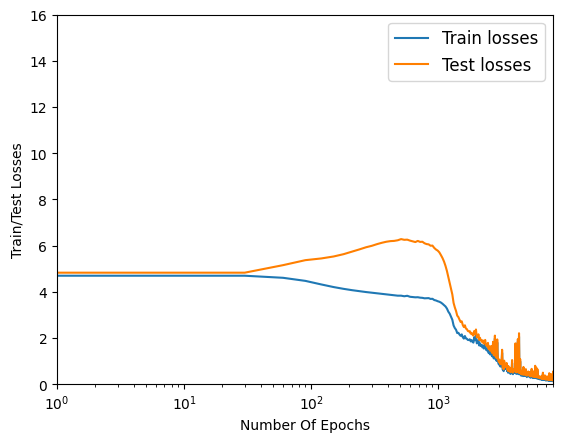

In [82]:
plt.figure
plt.plot(log_steps_6[:-1],train_losses_6, color=Z[1],label='Train losses')
plt.plot(log_steps_6[:-1],test_losses_6, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.ylim([0,16])
plt.xlim([1,8000])
plt.show()

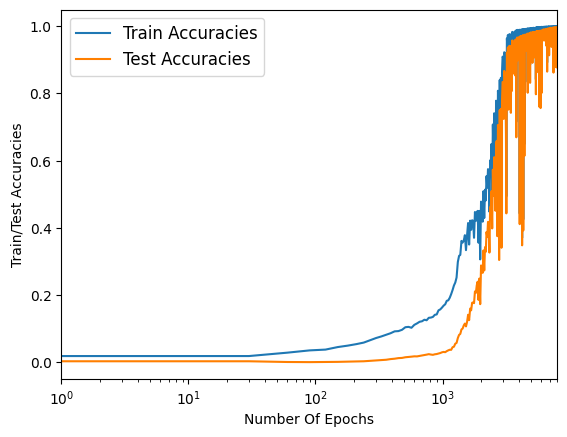

In [84]:
plt.figure
plt.plot(log_steps_6[:-1] ,train_accuracies_6 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps_6[:-1],test_accuracies_6, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.xlim([1,8000])
plt.show()

In [197]:
eigenvalues, eigenvectors = np.linalg.eig(Attn_wv_m_6[-1])

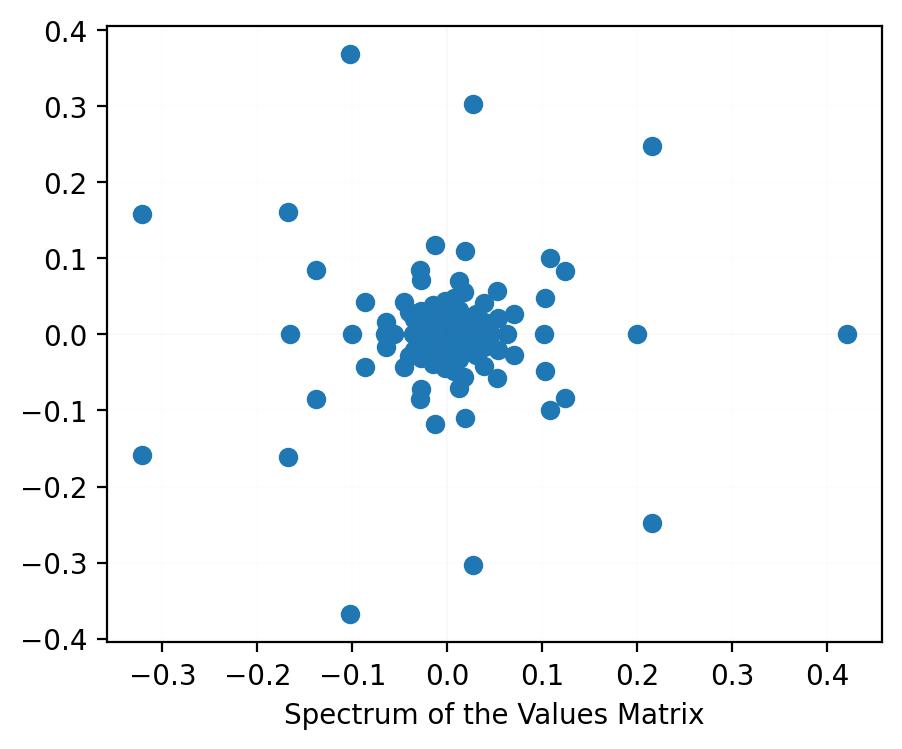

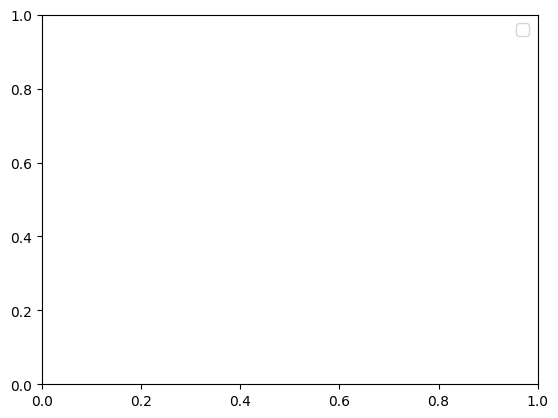

In [198]:
plt.figure(figsize=[5,4],dpi=200)
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of the Values Matrix')
filename = "SPV_6_Final.png"
plt.savefig(filename)
plt.show()
plt.legend()
plt.legend(fontsize='large')

# LoRA Fine-tuning (depth=6)

##Parameter of the model

In [92]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

Hyperparameters of the training

In [93]:
!pip install peft

In [94]:
import peft
import copy
import os

## Fine-tuning Configuration ($r=4$ as LoRA rank \text{ and } $V$ as unique parameter which is modified).

In [95]:
config = peft.LoraConfig(
    r=16,
    target_modules=["blocks.0.attn.value_matrix"]
)
lr=10e-5
model=model_6
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.AdamW(peft_model.parameters(), lr, betas=(0.9, 0.98))

peft_model.print_trainable_parameters()

trainable params: 4,096 || all params: 232,960 || trainable%: 1.7582417582417582


## Fine-tuning

In [96]:
lr=1e-5
wd=0.
epochs=15000

In [97]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.6

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [98]:
epochs=20000
train = data_train
test = data_test
Attn_wv_A_ft6=[]
Attn_wv_B_ft6=[]
Attn_wq_ft6=[]
Attn_wk_ft6=[]
log_steps = []
train_losses__ft6 = []
test_losses__ft6= []
train_accuracies__ft6 = []
test_accuracies__ft6 = []
test_accuracies__ft_plus6 = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(peft_model, train, device)
  if epoch % 30 == 0:
    for param_tensor in peft_model.state_dict():
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_A.default.weight':
            Attn_wv_A_ft6.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_B.default.weight':
            Attn_wv_B_ft6.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus6.append(full_accuracy(peft_model, data_test_plus, device))
            test_loss__1 = full_loss(peft_model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft6.append(train_loss.item())
            test_losses__ft6.append(test_loss__1.item())
            train_accuracies__ft6.append(full_accuracy(peft_model, train, device))
            test_accuracies__ft6.append(full_accuracy(peft_model, test, device))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | Test_mod_add: %.6f  "%(epoch, train_losses__ft6[-1], test_losses__ft6[-1], train_accuracies__ft6[-1], test_accuracies__ft6[-1],test_accuracies__ft_plus6[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/20000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 88.210075 |  Test loss: 90.498528 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.998434  
epoch: 30  | Train loss: 81.340652 |  Test loss: 83.268883 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.670217  
epoch: 60  | Train loss: 75.070732 |  Test loss: 76.532227 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.245673  
epoch: 90  | Train loss: 71.121719 |  Test loss: 72.337807 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.169551  
epoch: 120  | Train loss: 67.768639 |  Test loss: 68.918526 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.152557  
epoch: 150  | Train loss: 64.620689 |  Test loss: 65.728905 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.123972  
epoch: 180  | Train loss: 61.426449 |  Test loss: 62.510876 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.106821  
epoch: 210  | Train loss: 58.027744 |  Test loss: 59.106125 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.107369  
epoch: 240  | Train loss: 54.

## Vizualization of Loss, Accuracies curves

In [176]:
l=[30*i+10 for i in range(len(train_accuracies__ft6))]

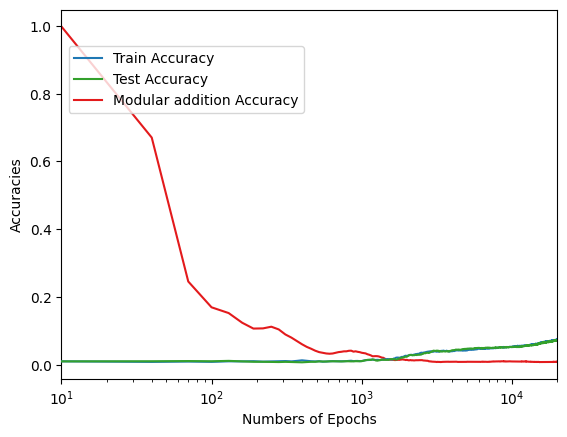

In [178]:
plt.plot(l, train_accuracies__ft6, color=Z[1], label='Train Accuracy ',zorder=3)
plt.plot(l, test_accuracies__ft6, color=Z[3], label='Test Accuracy',zorder=3)
plt.plot(l,test_accuracies__ft_plus6, color=Z[5], label='Modular addition Accuracy')
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(10, 2*10**4)
plt.xscale('log')
filename='ACC6.png'
plt.xscale('log')
plt.ylabel("Accuracies")
plt.legend(loc=(0.015, 0.72))
plt.savefig(filename)

In [ ]:
plt.plot(log_steps, train_losses__ft1, color=Z[1], label='Train Loss ',zorder=3)
plt.plot(log_steps, test_losses__ft1, color=Z[3], label='Test Loss',zorder=3)
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(1, 2*10**4)
plt.ylabel("Accuracies")
plt.legend(loc=(0.015, 0.72))

In [147]:
lora_A=model.blocks[0].attn.value_matrix.lora_A.default.weight.cpu().detach().numpy()
lora_B=model.blocks[0].attn.value_matrix.lora_B.default.weight.cpu().detach().numpy()
deltaW=lora_B@lora_A

In [148]:
eigenvalues_6=np.linalg.eigvals(deltaW+Attn_wv_m_6[-1])
eigenvalues_6_2=np.linalg.eigvals(Attn_wv_m_6[-1])

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]
spv=[np.linalg.eigvals(x) for x in wv]

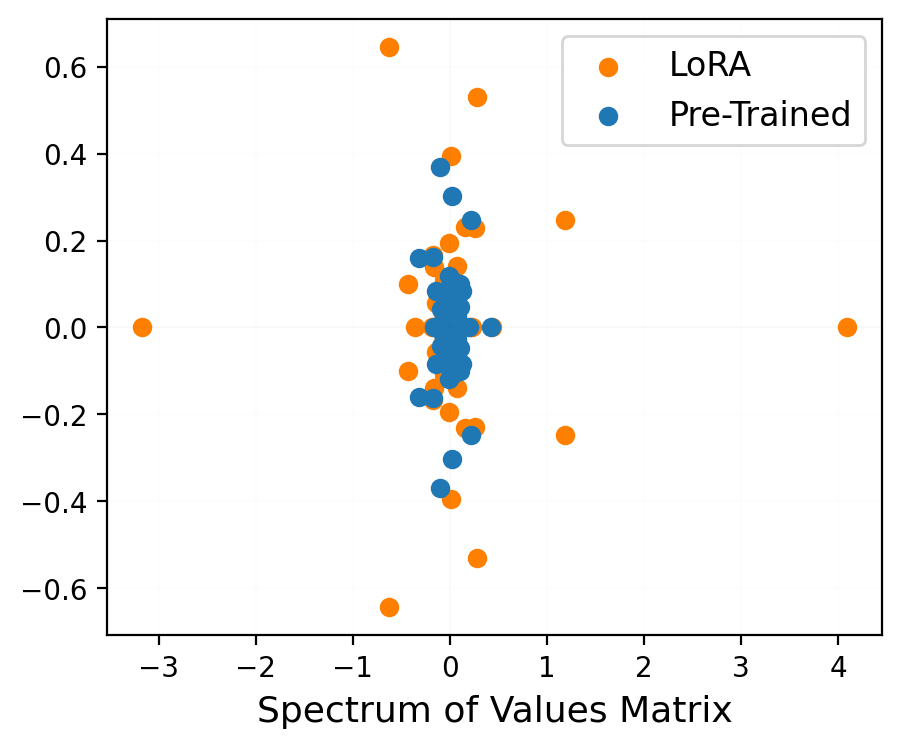

In [179]:
plt.figure(figsize=[5,4],dpi=200)
plt.scatter(np.real(eigenvalues_6), np.imag(eigenvalues_6), marker='o', color=Z[7],label='LoRA')
plt.scatter(np.real(eigenvalues_6_2), np.imag(eigenvalues_6_2), marker='o', color=Z[1],label='Pre-Trained')
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Spectrum of Values Matrix',fontsize='13')
filename='V_6'
plt.legend()
plt.legend(fontsize='large')
plt.savefig(filename)

# Training loop for modular addition (depth=8)

### Model declaration

In [ ]:
model_8 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=False, # use LayerNorm,
                    depth=8
                ).to(device)

### Training

In [ ]:
optimizer = torch.optim.AdamW(model_8.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=100, threshold=10e-8,verbose=True)
log_steps_8 = []
train_losses_8 = []
test_losses_8 = []
train_accuracies_8 = []
test_accuracies_8 = []
test_minus_8= []
norms_8 = []
Attn_wk_m_8=[]
Attn_wq_m_8=[]
Attn_wv_m_8=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_8, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_8.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_8.append(model_8.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_8.append(model_8.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_8.append(model_8.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_8.append(epoch)
          test_loss = full_loss(model_8, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_8.append(train_loss.item())
          test_losses_8.append(test_loss.item())
          train_accuracies_8.append(full_accuracy(model_8, train, device))
          test_accuracies_8.append(full_accuracy(model_8, test, device))
          norms_8.append(np.sqrt(sum(param.pow(2).sum().item() for param in model_8.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, train_losses_8[-1], test_losses_8[-1], train_accuracies_8[-1], test_accuracies_8[-1], norms_8[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()


In [ ]:
plt.figure
plt.plot(log_steps_8,train_losses_8, color=Z[1],label='Train losses')
plt.plot(log_steps_8,test_losses_8, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
#plt.ylabel('Train/Test Accuracies')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.ylim(0,15)
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
plt.style.use('default')
plt.figure
plt.plot(log_steps_8,train_accuracies_8, color=Z[1],label='Train accuracies')
plt.plot(log_steps_8,test_accuracies_8, color=Z[7],label='Test accuracies')
plt.legend(fontsize='large')
plt.ylabel('Train/Test Accuracies')
plt.xlabel('Number Of Epochs')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
rank_wk_8=[np.linalg.matrix_rank(x) for x in Attn_wk_m_8]
rank_wq_m_8=[np.linalg.matrix_rank(x) for x in Attn_wq_m_8]
rank_wv_m_8=[np.linalg.matrix_rank(x) for x in Attn_wv_m_8]

In [ ]:
rk_wk_8=[x/128 for x in rank_wk_8]
rk_wq_8=[x/128 for x in rank_wq_m_8]
rk_wv_8=[x/128 for x in rank_wv_m_8]

In [ ]:
eigenvalues_8, eigenvectors_8 = np.linalg.eig(Attn_wv_m_8[-1])

In [ ]:
plt.figure
plt.scatter(np.real(eigenvalues_8), np.imag(eigenvalues_8), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Eigenvalues of V')
plt.legend()
plt.legend(fontsize='large')

# LoRA Fine-tuning (depth=8)

##Parameter of the model

In [ ]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

Hyperparameters of the training

In [ ]:
!pip install peft

In [ ]:
import peft
import copy
import os

## Fine-tuning Configuration ($r=4$ as LoRA rank \text{ and } $V$ as unique parameter which is modified).

In [ ]:
config = peft.LoraConfig(
    r=16,
    target_modules=["blocks.0.attn.value_matrix"]
)
lr=10e-6
model=model_4
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.AdamW(peft_model.parameters(), lr, betas=(0.9, 0.98))

peft_model.print_trainable_parameters()

## Fine-tuning

In [ ]:
lr=1e-5
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
Attn_wv_A_ft1=[]
Attn_wv_B_ft1=[]
Attn_wq_ft1=[]
Attn_wk_ft1=[]
log_steps = []
train_losses__ft1 = []
test_losses__ft1= []
train_accuracies__ft1 = []
test_accuracies__ft1 = []
test_accuracies__ft_plus1 = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(peft_model, train, device)
  if epoch % 30 == 0:
    for param_tensor in peft_model.state_dict():
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_A.default.weight':
            Attn_wv_A_ft1.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='base_model.model.blocks.0.attn.value_matrix.lora_B.default.weight':
            Attn_wv_B_ft1.append(peft_model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus1.append(full_accuracy(peft_model, data_test_plus, device))
            test_loss__1 = full_loss(peft_model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft1.append(train_loss.item())
            test_losses__ft1.append(test_loss__1.item())
            train_accuracies__ft1.append(full_accuracy(peft_model, train, device))
            test_accuracies__ft1.append(full_accuracy(peft_model, test, device))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | Test_mod_add: %.6f  "%(epoch, train_losses__ft1[-1], test_losses__ft1[-1], train_accuracies__ft1[-1], test_accuracies__ft1[-1],test_accuracies__ft_plus1[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


## Vizualization of Loss, Accuracies curves

In [ ]:
plt.plot(log_steps, train_accuracies__ft1, color=Z[1], label='Train Accuracy ',zorder=3)
plt.plot(log_steps, test_accuracies__ft1, color=Z[3], label='Test Accuracy',zorder=3)
plt.plot(log_steps,test_accuracies__ft_plus1, color=Z[5], label='Modular addition Accuracy')
plt.legend()
plt.xlabel("Numbers of Epochs of LoRA")
plt.xlim(1, 1*10**4)
plt.ylabel("Accuracies")
plt.legend(loc=(0.015, 0.72))

In [ ]:
plt.plot(log_steps, train_losses__ft1, color=Z[1], label='Train Loss ',zorder=3)
plt.plot(log_steps, test_losses__ft1, color=Z[3], label='Test Loss',zorder=3)
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(1, 2*10**4)
plt.ylabel("Accuracies")
plt.legend(loc=(0.015, 0.72))

In [ ]:
wk= [Attn_wk_ft1[i] for i in range(len(Attn_wk_ft1))]
wq= [Attn_wq_ft1[i] for i in range(len(Attn_wq_ft1))]
#wv= [(Attn_wv_ft1[i]-Attn_wv_m_4[-1]) for i in range(len(Attn_wv_ft1))]

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
lora_A=model.blocks[0].attn.value_matrix.lora_A.default.weight.cpu().detach().numpy()
lora_B=model.blocks[0].attn.value_matrix.lora_B.default.weight.cpu().detach().numpy()
deltaW=lora_B@lora_A
wv= [(Attn_wv_A_ft1[i]@Attn_wv_B_ft1[i]) for i in range(len(Attn_wv_A_ft1))]

In [ ]:
Attn_wv_A_ft1

In [ ]:
Attn_wv_B_ft1

In [ ]:
eigenvalues=np.linalg.eigvals(deltaW)

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]
spv=[np.linalg.eigvals(x) for x in wv]

In [ ]:
#eigenvalues=np.linalg.eigvals(spv[0])
#eigenvalues_2=np.linalg.eigvals(spv[1])
plt.figure
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), marker='o', color=Z[1])
#plt.scatter(np.real(eigenvalues_2), np.imag(eigenvalues_2), marker='o', color=Z[0])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Eigenvalues of V',fontsize='13')
plt.legend()
plt.legend(fontsize='large')

### Model declaration

In [ ]:
model_4 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=False, # use LayerNorm,
                    depth=4
                ).to(device)

### Training

In [ ]:
optimizer = torch.optim.AdamW(model_4.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=100, threshold=10e-8,verbose=True)
log_steps_4 = []
train_losses_4 = []
test_losses_4 = []
train_accuracies_4 = []
test_accuracies_4 = []
test_minus_4= []
norms_4 = []
Attn_wk_m_4=[]
Attn_wq_m_4=[]
Attn_wv_m_4=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_4, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_4.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_4.append(model_4.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_4.append(epoch)
          test_loss = full_loss(model_4, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_4.append(train_loss.item())
          test_losses_4.append(test_loss.item())
          train_accuracies_4.append(full_accuracy(model_4, train, device))
          test_accuracies_4.append(full_accuracy(model_4, test, device))
          norms_4.append(np.sqrt(sum(param.pow(2).sum().item() for param in model_4.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, train_losses_4[-1], test_losses_4[-1], train_accuracies_4[-1], test_accuracies_4[-1], norms_4[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()


In [ ]:
plt.figure
plt.plot(log_steps_4,train_losses_4, color=Z[1],label='Train losses')
plt.plot(log_steps_4,test_losses_4, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
#plt.ylabel('Train/Test Accuracies')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
plt.figure
plt.plot(log_steps_4,train_accuracies_4, color=Z[1],label='Train accuracies')
plt.plot(log_steps_4,test_accuracies_4, color=Z[7],label='Test accuracies')
plt.legend(fontsize='large')
plt.ylabel('Train/Test Accuracies')
plt.xlabel('Number Of Epochs')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
rank_wk_4=[np.linalg.matrix_rank(x) for x in Attn_wk_m_4]
rank_wq_m_4=[np.linalg.matrix_rank(x) for x in Attn_wq_m_4]
rank_wv_m_4=[np.linalg.matrix_rank(x) for x in Attn_wv_m_4]

In [ ]:
rk_wk_4=[x/128 for x in rank_wk_4]
rk_wq_4=[x/128 for x in rank_wq_m_4]
rk_wv_4=[x/128 for x in rank_wv_m_4]

In [ ]:
eigenvalues_4, eigenvectors_4 = np.linalg.eig(Attn_wv_m_4[-1])

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100,figsize=[15,8])

ax[0].plot(log_steps_4, rk_wk_4, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
ax[0].plot(log_steps_4, rk_wv_4, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
ax[0].plot(log_steps_4, rk_wq_4, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[0].plot(log_steps_4, train_accuracies_4, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[0].plot(log_steps_4, test_accuracies_4, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[0].legend()
ax[0].set_ylabel('Train/Test Accuracies And Rank of attention matrices',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 5*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')
#ax[1].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

ax[1].plot(log_steps_4, train_losses_4, color=Z[5],linewidth=3, label='Train loss',zorder=3)
ax[1].plot(log_steps_4, test_losses_4, color=Z[4],linewidth=3, label='Test loss',zorder=3)
#ax[2].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
#ax[2].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
#ax[2].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Losses',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 5*10**4)
ax[1].set_xscale('log')
##ax[2].set_yscale('log')
ax[1].legend(fontsize='large')
#ax[2].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

In [ ]:
plt.figure
plt.scatter(np.real(eigenvalues_4), np.imag(eigenvalues_4), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Eigenvalues of V')
plt.legend()
plt.legend(fontsize='large')

# Training loop for modular addition (depth=16)

### Model declaration

In [ ]:
model_12 = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=False, # use LayerNorm,
                    depth=12
                ).to(device)

### Training

In [ ]:
optimizer = torch.optim.AdamW(model_12.parameters(), lr=1e-3, weight_decay=1., betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=100, threshold=10e-8,verbose=True)
log_steps_8 = []
train_losses_8 = []
test_losses_8 = []
train_accuracies_8 = []
test_accuracies_8 = []
test_minus_8= []
norms_8 = []
Attn_wk_m_8=[]
Attn_wq_m_8=[]
Attn_wv_m_8=[]
for epoch in tqdm(range(50000)):
  train_loss = full_loss(model_12, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
     for param_tensor in model_12.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_m_8.append(model_12.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_m_8.append(model_12.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_m_8.append(model_12.state_dict()[param_tensor].cpu().detach().numpy())
     with torch.no_grad():
          log_steps_8.append(epoch)
          test_loss = full_loss(model_12, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_8.append(train_loss.item())
          test_losses_8.append(test_loss.item())
          train_accuracies_8.append(full_accuracy(model_12, train, device))
          test_accuracies_8.append(full_accuracy(model_12, test, device))
          norms_8.append(np.sqrt(sum(param.pow(2).sum().item() for param in model_12.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, train_losses_8[-1], test_losses_8[-1], train_accuracies_8[-1], test_accuracies_8[-1], norms_8[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()


  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 3206.556152 |  Test loss: 3208.898438 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.688101
epoch: 30  | Train loss: 772.358154 |  Test loss: 813.344482 | train_acc: 0.01 | test_acc: 0.01 | l2: 45.261430
epoch: 60  | Train loss: 320.249176 |  Test loss: 373.056976 | train_acc: 0.01 | test_acc: 0.01 | l2: 44.913665
epoch: 90  | Train loss: 339.235718 |  Test loss: 393.688538 | train_acc: 0.01 | test_acc: 0.01 | l2: 44.638008
epoch: 120  | Train loss: 145.981750 |  Test loss: 192.531052 | train_acc: 0.01 | test_acc: 0.00 | l2: 44.394761
epoch: 150  | Train loss: 90.747711 |  Test loss: 130.439758 | train_acc: 0.01 | test_acc: 0.00 | l2: 44.160988
epoch: 180  | Train loss: 96.875130 |  Test loss: 132.390930 | train_acc: 0.01 | test_acc: 0.00 | l2: 43.946887
epoch: 210  | Train loss: 75.992714 |  Test loss: 108.498276 | train_acc: 0.01 | test_acc: 0.00 | l2: 43.749860
epoch: 240  | Train loss: 52.832569 |  Test loss: 81.434792 | train_acc: 0.02 | test_acc: 0.00 | l2: 4

In [ ]:
plt.figure
plt.plot(log_steps_8,train_losses_8, color=Z[1],label='Train losses')
plt.plot(log_steps_8,test_losses_8, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
#plt.ylabel('Train/Test Accuracies')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.ylim(0,15)
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
plt.style.use('default')
plt.figure
plt.plot(log_steps_8,train_accuracies_8, color=Z[1],label='Train accuracies')
plt.plot(log_steps_8,test_accuracies_8, color=Z[7],label='Test accuracies')
plt.legend(fontsize='large')
plt.ylabel('Train/Test Accuracies')
plt.xlabel('Number Of Epochs')
plt.xscale('log')
plt.xlim(1, 5*10**4)
plt.show()

In [ ]:
rank_wk_8=[np.linalg.matrix_rank(x) for x in Attn_wk_m_8]
rank_wq_m_8=[np.linalg.matrix_rank(x) for x in Attn_wq_m_8]
rank_wv_m_8=[np.linalg.matrix_rank(x) for x in Attn_wv_m_8]

In [ ]:
rk_wk_8=[x/128 for x in rank_wk_8]
rk_wq_8=[x/128 for x in rank_wq_m_8]
rk_wv_8=[x/128 for x in rank_wv_m_8]

In [ ]:
eigenvalues_8, eigenvectors_8 = np.linalg.eig(Attn_wv_m_8[-1])

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100,figsize=[15,8])

ax[0].plot(log_steps_4, rk_wk_8, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
ax[0].plot(log_steps_4, rk_wv_8, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
ax[0].plot(log_steps_4, rk_wq_8, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[0].plot(log_steps_4, train_accuracies_8, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[0].plot(log_steps_4, test_accuracies_8, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[0].legend()
ax[0].set_ylabel('Train/Test Accuracies And Rank of attention matrices',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 5*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')
#ax[1].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

ax[1].plot(log_steps_4, train_losses_8, color=Z[5],linewidth=3, label='Train loss',zorder=3)
ax[1].plot(log_steps_4, test_losses_8, color=Z[4],linewidth=3, label='Test loss',zorder=3)
#ax[2].plot(log_steps, rk_wk, color=Z[0], linewidth=3, label='W_K rank',zorder=4)
#ax[2].plot(log_steps, rk_wv, color=Z[3],linewidth=3,label='W_V rank',zorder=1)
#ax[2].plot(log_steps, rk_wq, color=Z[1],linewidth=3, label='W_Q rank',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Losses',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 5*10**4)
ax[1].set_xscale('log')
##ax[2].set_yscale('log')
ax[1].legend(fontsize='large')
#ax[2].set_title("Rank dynamics of attention matrices in the second layer".capitalize(),fontsize='large')

In [ ]:
plt.figure
plt.scatter(np.real(eigenvalues_8), np.imag(eigenvalues_8), marker='o', color=Z[1])
plt.axhline(0, color='black',linewidth=0.01)
plt.axvline(0, color='black',linewidth=0.01)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.01)
plt.xlabel('Eigenvalues of V')
plt.legend()
plt.legend(fontsize='large')